# Trajectory Batch Post-Analysis — Documentation

## Purpose
Aggregate per-trajectory metrics CSVs. Compute run-level summaries. Estimate scattering probability. Plot global distributions and correlations.

---

## Inputs
- **Directory:** `base_dir = example: "Normal_300K_01eV_results"`
- **File pattern:** chosen by `format`
  - `format = "LAMMPS"` → `pattern = "nve_*_metrics.csv"`
  - `format = "VASP"`   → `pattern = "vasprun-*_*metrics.csv"`
- **Per-file schema** (subset used):
  - `t_idx`
  - `COM_z-ztop(Å)`
  - `d_NO(Å)`
  - `Ecm(eV)`, `Evib_tot(eV)`, `Erot(eV)`
  - `Vcm_x(Å/fs)`, `Vcm_y(Å/fs)`, `Vcm_z(Å/fs)`
  - optional `outcome` or `output` (0/1 flags)

---

## Parameters
- `scatter_z = 7.0` Å. Height threshold for geometric scatter fallback.
- `roll_window = 25`. Smoothing window (prepared, not applied in plots).
- `total_mass_amu = None`. If set (e.g., `30.006` for NO), enables kinetic energy fallback from velocities.

---



In [16]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm as tqdm
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tqdm
from cycler import cycler
#sns.set(style="whitegrid", context="talk", font_scale=1.1)

specify_mpl_style = True
if specify_mpl_style:
    plt.style.use("/Users/samuel/Desktop/postdoc_PhLAM/codes/mystyle.mplstyle")

import matplotlib.style as mplstyle
mplstyle.use('fast') #The fast style set simplification and chunking parameters to reasonable settings to speed up plotting large amounts of data



Bad key legend.ncol in file /Users/samuel/Desktop/postdoc_PhLAM/codes/mystyle.mplstyle, line 37 ('legend.ncol: 1')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [8]:
# %% User settings
base_dir = Path("results/Normal_100K_18eV_results")   # <── change this
scatter_z = 7.0                           # Å threshold for scattering
roll_window = 25                          # smoothing window (frames)

format = "LAMMPS"           
#format = "VASP"                       # file format info only

if format == "VASP":
    pattern = "vasprun-*_*metrics.csv"   # matches vasprun-X_full_metrics.csv
elif format == "LAMMPS":
    pattern = "nve_*_metrics.csv"        # matches nve_XXX_metrics.csv
else:
    raise ValueError(f"Unknown format: {format}")

# --- collectors ---
n_total = 0
n_scattered = 0

j_scattered = []       # j_rot at first scatter
theta_scattered = []   # Vcm_theta(°) at first scatter

evib_all = []          # Evib per trajectory: at first scatter if scattered, else last frame
evib_scattered = []    # Evib at first scatter
evib_adsorbed = []     # Evib at last frame when not scattered

# %% Collect all metric files
files = sorted(base_dir.glob(pattern))
print(f"Found {len(files)} files.")
if not files:
    raise FileNotFoundError(f"No files matching {pattern} in {base_dir}")


Found 2044 files.


In [9]:
# %% Helper functions
def roll(x, n=roll_window):
    if n <= 1:
        return x
    return pd.Series(x).rolling(
        n, min_periods=max(1, n // 5), center=True
    ).mean().to_numpy()

def summarize(x):
    return dict(
        mean=float(np.nanmean(x)),
        std=float(np.nanstd(x)),
        min=float(np.nanmin(x)),
        max=float(np.nanmax(x)),
    )

def _sns_hist(arr, title, xlab, color="slateblue"):
    arr = [x for x in arr if np.isfinite(x)]
    if not arr:
        print(f"No samples for {title}"); return
    sns.histplot(arr, bins=30, color=color, stat='probability')
    plt.xlabel(xlab); plt.ylabel("Probability"); plt.title(title)
    plt.show()

# --- Helpers for angle-resolved rotational analysis -------------------------
def plot_rot_dist_for_angle_range(j_vals, th_vals, th_min, th_max, ax=None, label=None):
    """
    Plot rotational level distribution for trajectories whose scattering angle
    theta is in [th_min, th_max) degrees.
    """
    j_vals = np.asarray(j_vals, float)
    th_vals = np.asarray(th_vals, float)

    mask = (th_vals >= th_min) & (th_vals < th_max)
    j_sel = j_vals[mask]

    if j_sel.size == 0:
        print(f"No scattered trajectories in angle range [{th_min}, {th_max})°")
        return

    if ax is None:
        fig, ax = plt.subplots()

    bins = np.arange(np.floor(j_sel.min()) - 0.5,
                     np.ceil(j_sel.max()) + 1.5, 1)

    sns.histplot(
        j_sel,
        bins=bins,
        kde=False,
        stat="probability",
        ax=ax
    )
    ax.set_xlabel("j_rot")
    ax.set_ylabel("Probability")
    if label is None:
        label = f"{th_min}° ≤ θ < {th_max}°"
    ax.set_title(f"Rotational distribution — {label}")

    print(f"[{th_min},{th_max})°: n = {j_sel.size}, "
          f"<J> = {np.mean(j_sel):.2f}, "
          f"<J>_deg = {np.average(j_sel, weights=2*j_sel+1):.2f}")


def plot_J_theta_correlation(j_vals, th_vals):
    """
    Plot correlation between rotational quantum number J and scattering angle θ.
    """
    j_vals = np.asarray(j_vals, float)
    th_vals = np.asarray(th_vals, float)

    fig, ax = plt.subplots()
    sns.scatterplot(x=th_vals, y=j_vals, s=15, alpha=0.6, ax=ax)
    ax.set_xlabel("Vcm_theta (°)")
    ax.set_ylabel("j_rot")
    ax.set_title("Correlation between j_rot and scattering angle (scattered)")
    plt.tight_layout()
    plt.show()

    # Optional: print simple correlation coefficient
    if j_vals.size > 1:
        corr = np.corrcoef(th_vals, j_vals)[0, 1]
        print(f"Pearson corr(J, θ) = {corr:.3f}")

100%|██████████| 2044/2044 [00:02<00:00, 756.14it/s]


Summary table:
Scattering probability = 1.000  (2044/2044)


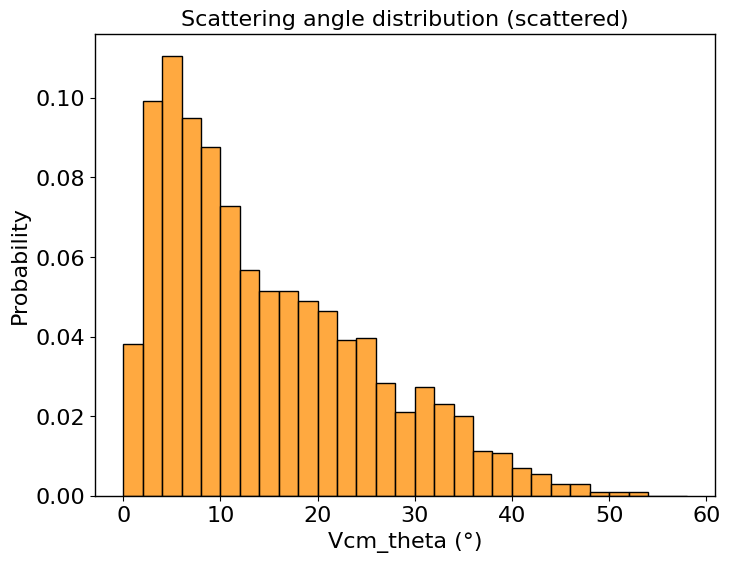

Mean j_rot (scattered):               17.23972602739726
Weighted mean j_rot (2J+1, scattered): 23.45750137892995


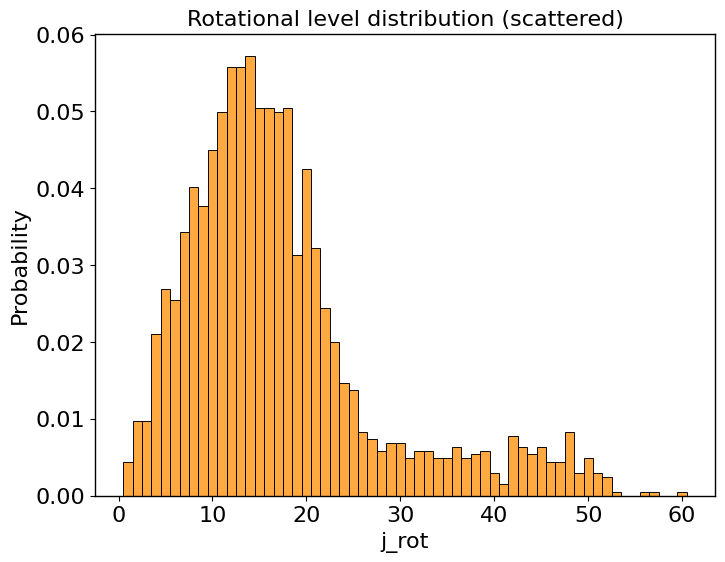

[0,5)°: n = 406, <J> = 18.44, <J>_deg(2J+1) = 25.32


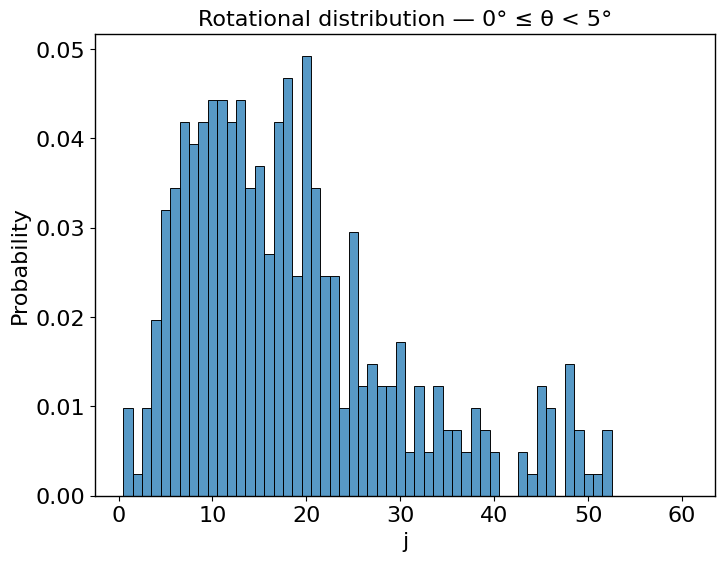

[5,10)°: n = 474, <J> = 20.12, <J>_deg(2J+1) = 27.27


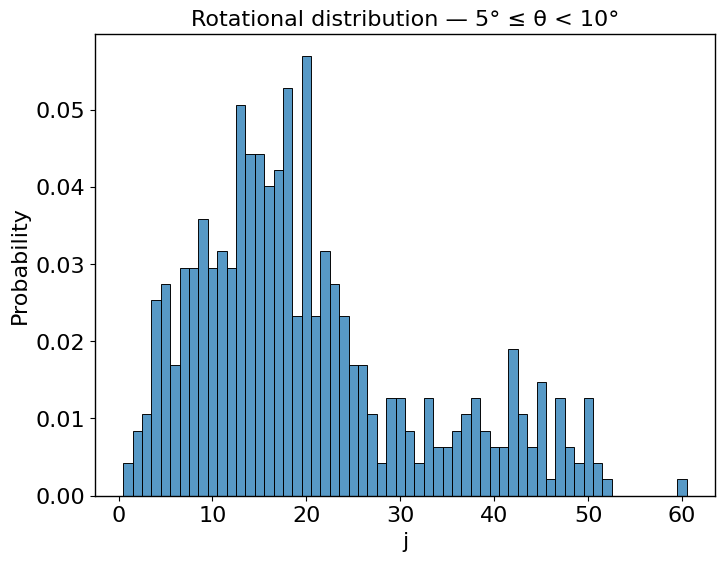

[10,20)°: n = 575, <J> = 17.36, <J>_deg(2J+1) = 24.04


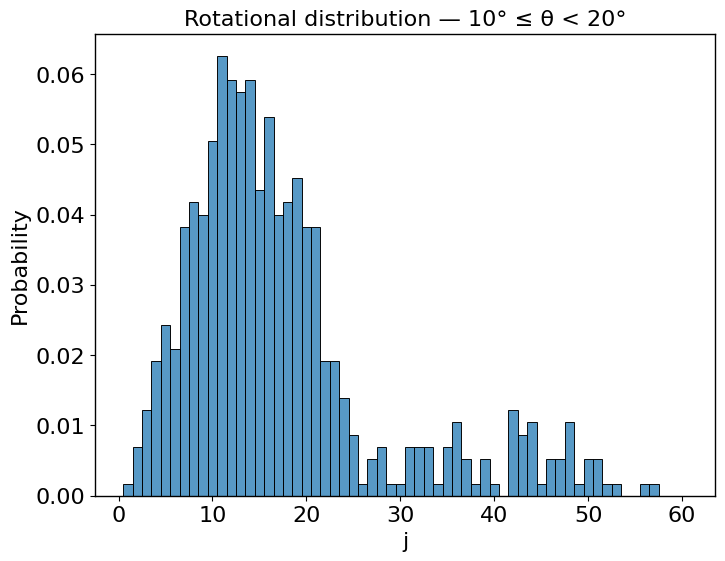

[20,30)°: n = 357, <J> = 14.07, <J>_deg(2J+1) = 17.27


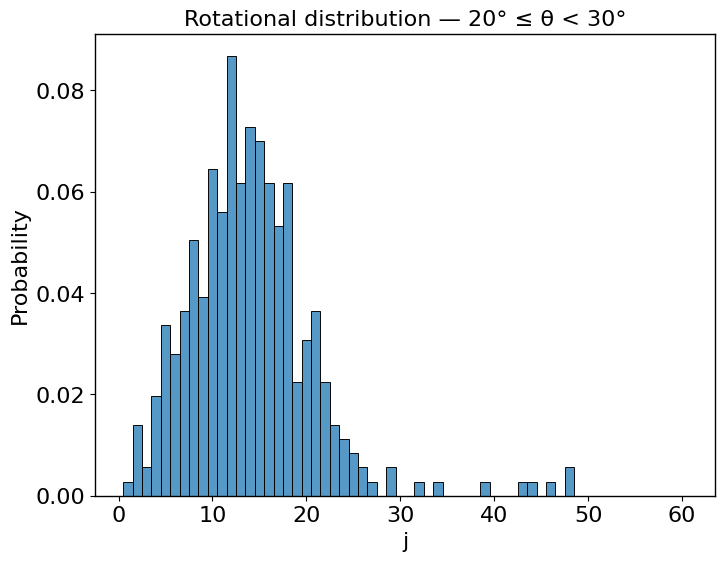

[30,40)°: n = 189, <J> = 13.69, <J>_deg(2J+1) = 15.89


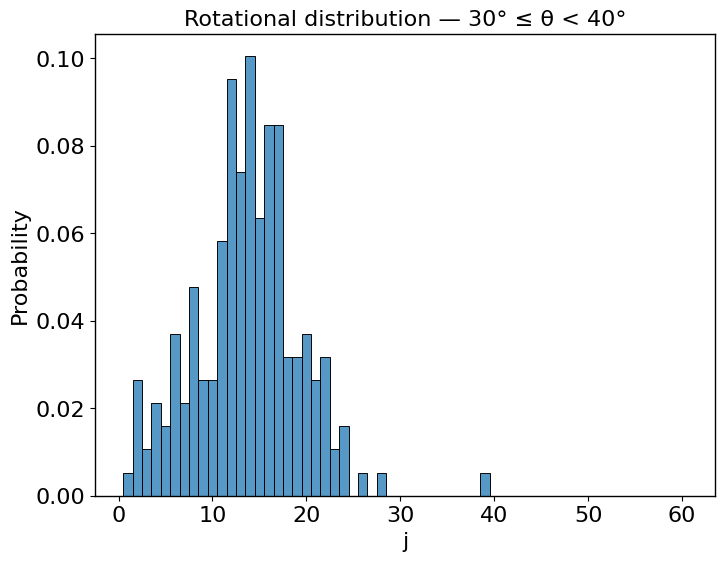

[40,50)°: n = 39, <J> = 14.31, <J>_deg(2J+1) = 15.55


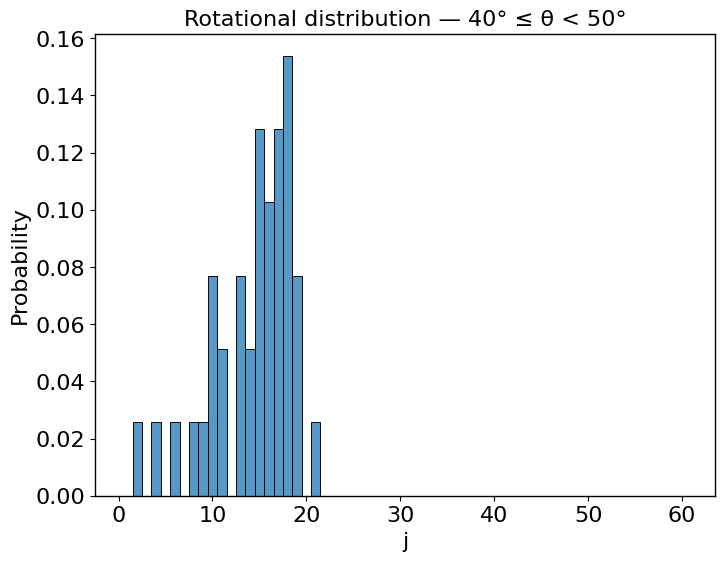

[50,90)°: n = 4, <J> = 16.50, <J>_deg(2J+1) = 16.63


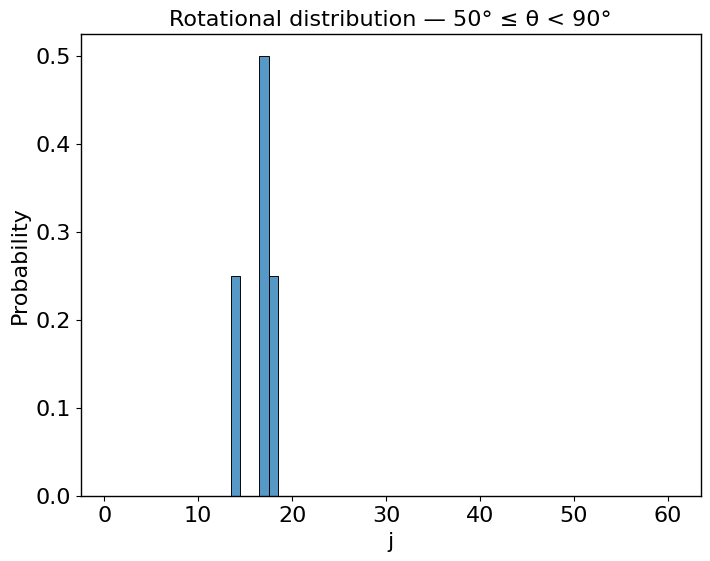

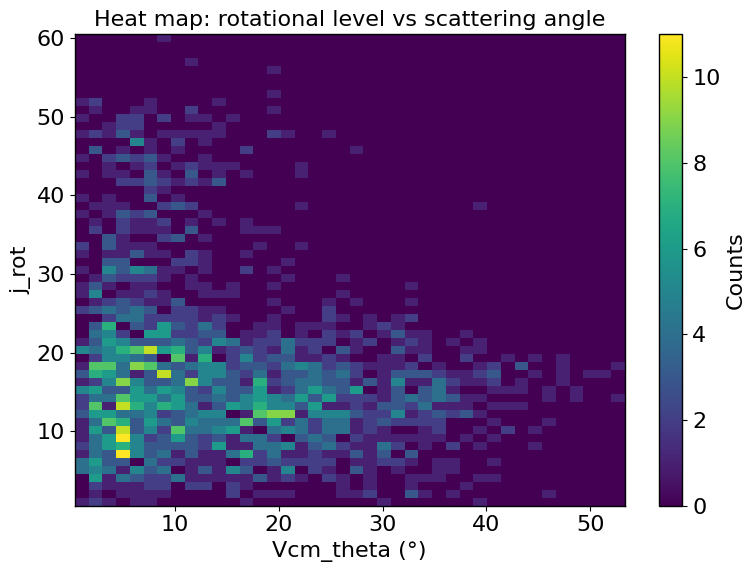

Pearson corr(J, θ) = -0.204


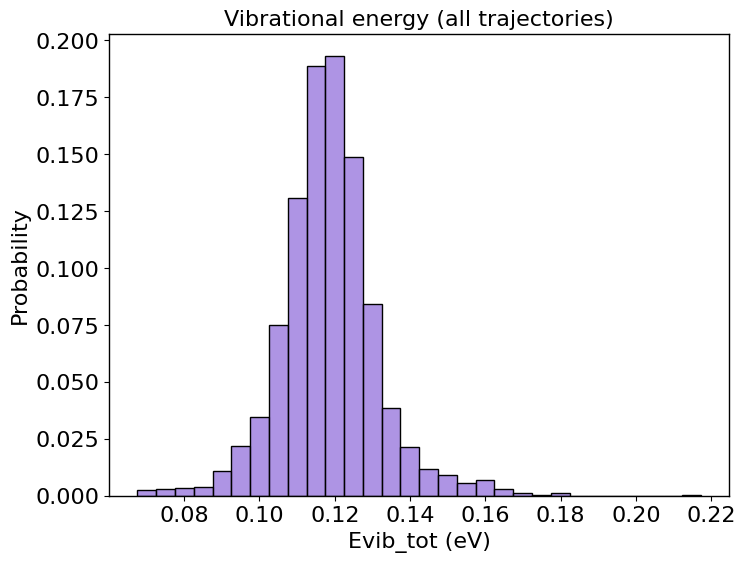

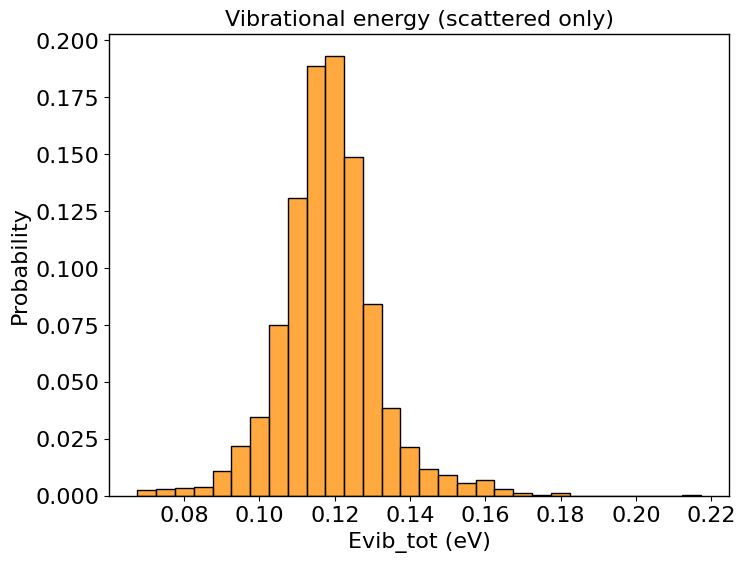

No samples for Vibrational energy (adsorbed only)


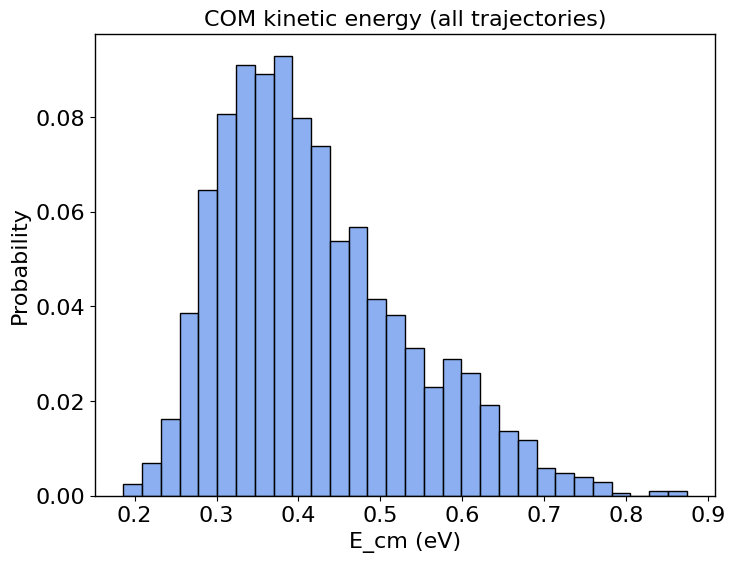

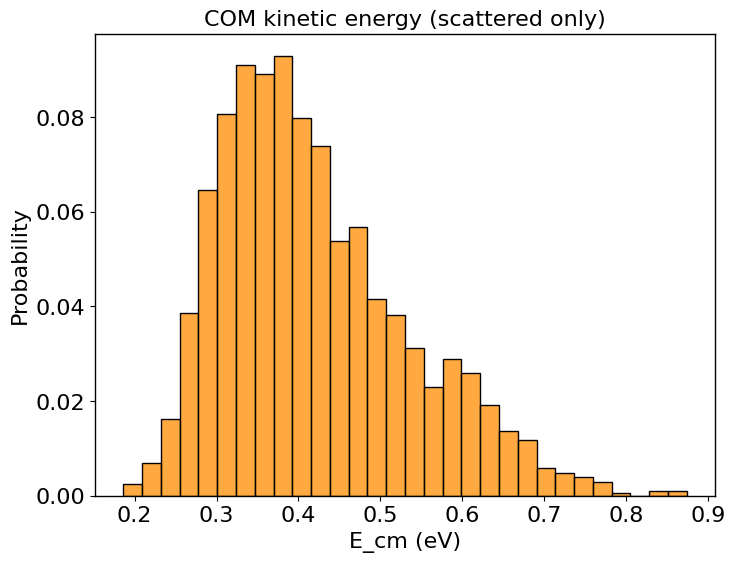

No samples for COM kinetic energy (adsorbed only)


In [10]:
# %% Loop over all trajectories + requested distributions (+ COM kinetic energy)
summaries = []

# collectors
n_total = 0
n_scattered = 0
j_scattered = []
theta_scattered = []
evib_all, evib_scattered, evib_adsorbed = [], [], []

# COM kinetic energy (eV)
Kcm_all, Kcm_scattered, Kcm_adsorbed = [], [], []

# if Ecm(eV) is absent, optionally compute from Vcm and total mass (amu)
total_mass_amu = None  # set e.g. 30.006 for NO; leave None to skip fallback

for path in tqdm.tqdm(files):
    df = pd.read_csv(path)
    if format == "VASP":
        df = df.iloc[1:].reset_index(drop=True)
    if "t_idx" not in df.columns or "COM_z-ztop(Å)" not in df.columns:
        print(f"Skipping {path.name} (missing columns)")
        continue

    n_total += 1

    t   = df["t_idx"].to_numpy()
    z   = df["COM_z-ztop(Å)"].to_numpy()
    dNO = df.get("d_NO(Å)", pd.Series(np.nan, index=df.index)).to_numpy()
    Ecm = df.get("Ecm(eV)",  pd.Series(np.nan, index=df.index)).to_numpy()
    Evib_tot = df.get("Evib_tot(eV)", pd.Series(np.nan, index=df.index)).to_numpy()
    Erot = df.get("Erot(eV)", pd.Series(np.nan, index=df.index)).to_numpy()

    # prefer explicit flag column; fall back to geometric threshold
    flag_col = "outcome" if "outcome" in df.columns else ("output" if "output" in df.columns else None)
    if flag_col is not None:
        flags = df[flag_col].to_numpy()
        scattered = np.any(flags == 1)
        first_scatter = int(np.argmax(flags == 1)) if scattered else None
    else:
        geo = (z >= scatter_z)
        scattered = bool(geo.any())
        first_scatter = int(np.argmax(geo)) if scattered else None

    # ----- summary table -----
    summaries.append({
        "file": path.name,
        "n_frames": len(df),
        "scattered": bool(scattered),
        "first_scatter_idx": first_scatter,
        "mean_z": float(np.nanmean(z)),
        "max_z": float(np.nanmax(z)),
        "mean_Ecm": float(np.nanmean(Ecm)),
        "mean_Evib": float(np.nanmean(Evib_tot)),
        "mean_Erot": float(np.nanmean(Erot)),
    })

    # ----- index to sample for distributions -----
    if scattered:
        n_scattered += 1
        i = first_scatter
        if "j_rot" in df.columns and pd.notna(df.loc[i, "j_rot"]):
            j_scattered.append(float(df.loc[i, "j_rot"]))
        if "Vcm_theta(°)" in df.columns and pd.notna(df.loc[i, "Vcm_theta(°)"]):
            theta_scattered.append(float(df.loc[i, "Vcm_theta(°)"]))
        if pd.notna(df.loc[i, "Evib_tot(eV)"]):
            ev = float(df.loc[i, "Evib_tot(eV)"])
            evib_scattered.append(ev); evib_all.append(ev)
        if "Ecm(eV)" in df.columns and pd.notna(df.loc[i, "Ecm(eV)"]):
            kc = float(df.loc[i, "Ecm(eV)"])
        elif total_mass_amu is not None and {"Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"} <= set(df.columns):
            vx, vy, vz = df.loc[i, ["Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"]].to_numpy(dtype=float)
            v = np.sqrt(vx*vx + vy*vy + vz*vz) * 1e5
            kc = 0.5 * (total_mass_amu*1.66053906660e-27) * v*v / 1.602176634e-19
        else:
            kc = np.nan
        Kcm_scattered.append(kc); Kcm_all.append(kc)
    else:
        print(f"Not scattered: {path.name}")
        i = len(df) - 1
        #if "j_rot" in df.columns and pd.notna(df.loc[i, "j_rot"]):
        #    j_scattered.append(float(df.loc[i, "j_rot"]))
        if "Evib_tot(eV)" in df.columns and pd.notna(df.loc[i, "Evib_tot(eV)"]):
            ev = float(df.loc[i, "Evib_tot(eV)"])
            evib_adsorbed.append(ev); evib_all.append(ev)
        if "Ecm(eV)" in df.columns and pd.notna(df.loc[i, "Ecm(eV)"]):
            kc = float(df.loc[i, "Ecm(eV)"])
        elif total_mass_amu is not None and {"Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"} <= set(df.columns):
            vx, vy, vz = df.loc[i, ["Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"]].to_numpy(dtype=float)
            v = np.sqrt(vx*vx + vy*vy + vz*vz) * 1e5
            kc = 0.5 * (total_mass_amu*1.66053906660e-27) * v*v / 1.602176634e-19
        else:
            kc = np.nan
        Kcm_adsorbed.append(kc); Kcm_all.append(kc)

# %% Combine all summaries
summary_df = pd.DataFrame(summaries)
print("\nSummary table:")
#display(summary_df)

# %% Seaborn-based global overview plots
# plt.figure(figsize=(7, 4))
# sns.histplot(summary_df["max_z"], bins=20, kde=False, color="steelblue")
# plt.xlabel("Max COM_z-ztop (Å)"); plt.ylabel("Count")
# plt.title("Distribution of max COM heights across runs")
# plt.show()

# sns.scatterplot(data=summary_df, x="mean_Ecm", y="mean_Evib",
#                 hue="max_z", palette="viridis", edgecolor=None)
# plt.colorbar = plt.colorbar
# plt.xlabel("Mean Ecm (eV)"); plt.ylabel("Mean Evib (eV)")
# plt.title("Energy correlation across runs")
# plt.tight_layout(); plt.show()

# %% Scattering probability
p_scat = n_scattered / n_total if n_total else np.nan
print(f"Scattering probability = {p_scat:.3f}  ({n_scattered}/{n_total})")

# Rotational level + angle analysis (scattered)
if j_scattered and theta_scattered:
    j_arr  = np.asarray(j_scattered, float)
    th_arr = np.asarray(theta_scattered, float)

    # --- Scattering angle distribution ---
    sns.histplot(
        th_arr,
        bins=np.arange(0, np.max(th_arr) + 5, 2),
        kde=False, color="darkorange", stat='probability'
    )
    plt.xlabel("Vcm_theta (°)"); plt.ylabel("Probability")
    plt.title("Scattering angle distribution (scattered)")
    plt.show()

    # --- 1) Global rotational distribution ---
    sns.histplot(
        j_arr,
        bins=np.arange(np.floor(j_arr.min()) - 0.5,
                       np.ceil(j_arr.max()) + 1.5, 1),
        kde=False, color="darkorange", stat='probability'
    )
    plt.xlabel("j_rot"); plt.ylabel("Probability")
    plt.title("Rotational level distribution (scattered)")
    print("Mean j_rot (scattered):              ", np.mean(j_arr))
    print("Weighted mean j_rot (2J+1, scattered):",
          np.average(j_arr, weights=2*j_arr + 1))
    plt.show()

    # --- 2) Rotational distribution in angle ranges ---
    angle_bins = [(0, 5), (5, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 90)]  # change as you wish
    for th_min, th_max in angle_bins:
        mask = (th_arr >= th_min) & (th_arr < th_max)
        j_sel = j_arr[mask]
        if j_sel.size == 0:
            print(f"No scattered trajectories in angle range [{th_min}, {th_max})°")
            continue

        sns.histplot(
            j_sel,
            bins=np.arange(np.floor(j_arr.min()) - 0.5,
                           np.ceil(j_arr.max()) + 1.5, 1),
            kde=False, stat='probability'
        )
        plt.xlabel("j"); plt.ylabel("Probability")
        plt.title(f"Rotational distribution — {th_min}° ≤ θ < {th_max}°")
        print(f"[{th_min},{th_max})°: n = {j_sel.size}, "
              f"<J> = {np.mean(j_sel):.2f}, "
              f"<J>_deg(2J+1) = {np.average(j_sel, weights=2*j_sel+1):.2f}")
        plt.show()

    # --- 3) Heat-map correlation J vs scattering angle ---

    # Convert to arrays
    j_arr  = np.asarray(j_scattered, float)
    th_arr = np.asarray(theta_scattered, float)

    # Choose number of bins (tune as you wish)
    Nbins_theta = 40
    Nbins_J     = int(np.ceil(j_arr.max()) - np.floor(j_arr.min())) #+ 5

    theta_bins = np.linspace(th_arr.min(), th_arr.max(), Nbins_theta+1)
    j_bins     = np.linspace(j_arr.min()-0.5, j_arr.max()+0.5, Nbins_J+1)

    H, xe, ye = np.histogram2d(th_arr, j_arr, bins=[theta_bins, j_bins])

    #plt.figure(figsize=(6,5))
    plt.pcolormesh(xe, ye, H.T, cmap="viridis")
    plt.colorbar(label="Counts")

    plt.xlabel("Vcm_theta (°)")
    plt.ylabel("j_rot")
    plt.title("Heat map: rotational level vs scattering angle")
    plt.tight_layout()
    plt.show()

    # Optional: Pearson correlation printed as before
    if j_arr.size > 1:
        corr = np.corrcoef(th_arr, j_arr)[0, 1]
        print(f"Pearson corr(J, θ) = {corr:.3f}")

elif j_scattered and not theta_scattered:
    # fallback: only J distribution
    j_arr = np.asarray(j_scattered, float)
    sns.histplot(
        j_arr,
        bins=np.arange(np.floor(j_arr.min()) - 0.5,
                       np.ceil(j_arr.max()) + 1.5, 1),
        kde=False, color="darkorange", stat='probability'
    )
    plt.xlabel("j_rot"); plt.ylabel("Probability")
    plt.title("Rotational level distribution (scattered)")
    print("Mean j_rot (scattered):              ", np.mean(j_arr))
    print("Weighted mean j_rot (2J+1, scattered):",
          np.average(j_arr, weights=2*j_arr + 1))
    plt.show()
else:
    print("No j_rot samples for scattered molecules.")

# --- 4) Heat-map correlation between vibrational energy and j_rot ---

# if j_scattered and evib_scattered:
#     j_arr    = np.asarray(j_scattered, float)
#     evib_arr = np.asarray(evib_scattered, float)  # Evib_tot(eV) from SAME i-index
    
#     # Build bins (tune numbers as needed)
#     Nbins_J     = int(np.ceil(j_arr.max()) - np.floor(j_arr.min())) + 5
#     Nbins_Evib  = 40

#     J_bins    = np.linspace(j_arr.min()-0.5, j_arr.max()+0.5, Nbins_J+1)
#     Evib_bins = np.linspace(evib_arr.min(), evib_arr.max(), Nbins_Evib+1)

#     # 2D histogram: J on y-axis, Evib on x-axis
#     H, xe, ye = np.histogram2d(evib_arr, j_arr,
#                                bins=[Evib_bins, J_bins])

#     #plt.figure(figsize=(6,5))
#     plt.pcolormesh(xe, ye, H.T, cmap="viridis")
#     plt.colorbar(label="Counts")

#     plt.xlabel("Vibrational energy Evib_tot (eV)")
#     plt.ylabel("j")
#     plt.title("Heat map: rotational level vs vibrational energy")
#     plt.tight_layout()
#     plt.show()

#     # Optional: Pearson correlation
#     if j_arr.size > 1:
#         corr = np.corrcoef(evib_arr, j_arr)[0, 1]
#         print(f"Pearson corr(J, Evib_tot) = {corr:.3f}")

# else:
#     print("Not enough data for J–Evib correlation.")


# Vibrational and COM kinetic energy distributions

_sns_hist(evib_all,       "Vibrational energy (all trajectories)",       "Evib_tot (eV)", "mediumpurple")
_sns_hist(evib_scattered, "Vibrational energy (scattered only)",         "Evib_tot (eV)", "darkorange")
_sns_hist(evib_adsorbed,  "Vibrational energy (adsorbed only)",          "Evib_tot (eV)", "gray")

_sns_hist(Kcm_all,        "COM kinetic energy (all trajectories)",       "E_cm (eV)", "cornflowerblue")
_sns_hist(Kcm_scattered,  "COM kinetic energy (scattered only)",         "E_cm (eV)", "darkorange")
_sns_hist(Kcm_adsorbed,   "COM kinetic energy (adsorbed only)",          "E_cm (eV)", "gray")

T_rot = 1037.9 K  (±23.0 K)


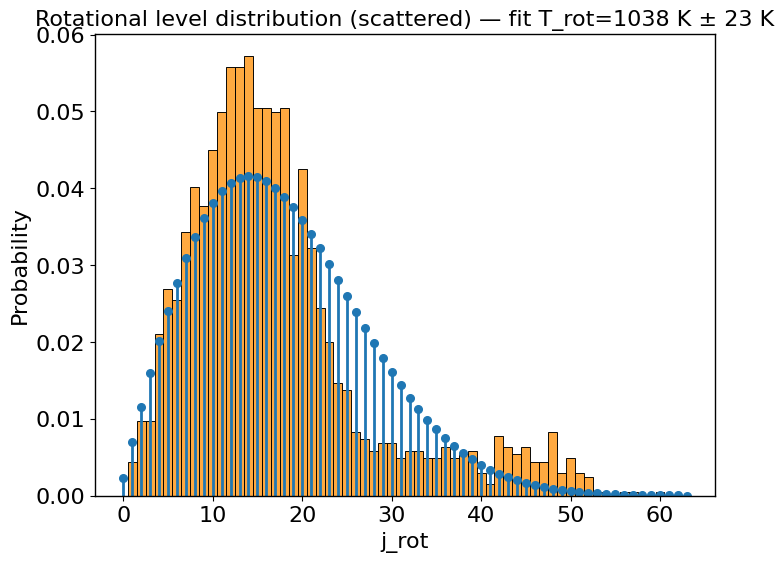

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.constants import k as kB

# --- constants for NO (X^2Π) ---
B_cm = 1.696            # rotational constant (cm^-1)
hc   = 1.98630e-23      # J·cm
B_J  = B_cm * hc        # J

def E_J(J):
    # rigid-rotor energy in Joules
    return B_J * J * (J + 1.0)

def g_J(J, extra=1.0):
    # rotational degeneracy; set extra=2.0 if you want to fold in an extra ladder
    return extra * (2.0*J + 1.0)

def neg_loglike(T, J_obs, Jgrid, extra_g=1.0):
    # partition function over the observed support (or extend Jgrid if needed)
    E = E_J(Jgrid)
    w = g_J(Jgrid, extra=extra_g) * np.exp(-E / (kB*T))
    Z = w.sum()
    # probability mass on each J value
    p = w / Z
    # log-likelihood of samples
    # convert observations to integer indices on the grid
    # if non-integer J are present, round to nearest integer level
    Ji = np.rint(J_obs).astype(int)
    # map Ji to grid indices
    idx = Ji - Jgrid[0]
    # guard: ignore any J outside the grid
    idx = idx[(idx >= 0) & (idx < len(Jgrid))]
    # accumulate log probabilities
    ll = np.log(p[idx]).sum()
    return -ll

def fit_Trot_MLE(j_samples, g_extra=1.0, Jpad=3, T_bounds=(1.0, 5000.0)):
    j_samples = np.asarray(j_samples, float)
    if j_samples.size == 0:
        raise ValueError("No j_rot samples.")
    # build J grid covering the observed support
    jmin = int(np.floor(j_samples.min()))
    jmax = int(np.ceil(j_samples.max()))
    Jgrid = np.arange(max(0, jmin - Jpad), jmax + Jpad + 1, dtype=int)

    obj = lambda T: neg_loglike(T, j_samples, Jgrid, extra_g=g_extra)
    res = minimize_scalar(obj, bounds=T_bounds, method="bounded")
    T_fit = float(res.x)

    # curvature-based 1σ uncertainty from second derivative (numeric)
    eps = 1e-2 * T_fit if T_fit > 0 else 1e-2
    f0  = obj(T_fit)
    fp  = obj(T_fit + eps)
    fm  = obj(T_fit - eps)
    d2  = (fp - 2*f0 + fm) / (eps**2)
    sigma_T = np.sqrt(1.0 / d2) if d2 > 0 else np.nan

    return T_fit, sigma_T, Jgrid

# ===== integrate with your existing block =====
if j_scattered:
    j_arr = np.asarray(j_scattered, float)

    # Fit T_rot
    T_rot, T_err, Jgrid = fit_Trot_MLE(j_arr, g_extra=1.0)  # set g_extra=2.0 if you want to include an extra ladder
    print(f"T_rot = {T_rot:.1f} K  (±{T_err:.1f} K)")

    # Compare model to histogram
    import seaborn as sns
    sns.histplot(
        j_arr,
        bins=np.arange(np.floor(j_arr.min())-0.5, np.ceil(j_arr.max())+1.5, 1),
        kde=False, color="darkorange", stat='probability'
    )

    # overlay discrete Boltzmann PMF
    E = E_J(Jgrid)
    w = g_J(Jgrid, 1.0) * np.exp(-E/(kB*T_rot))
    pJ = w / w.sum()

    # draw as stems centered at integer J
    plt.stem(Jgrid, pJ, basefmt=" ")
    plt.xlabel("j_rot")
    plt.ylabel("Probability")
    ttl = f"Rotational level distribution (scattered) — fit T_rot={T_rot:.0f} K"
    if np.isfinite(T_err):
        ttl = f"{ttl} ± {T_err:.0f} K"
    plt.title(ttl)
    plt.show()

else:
    print("No j_rot samples for scattered molecules.")

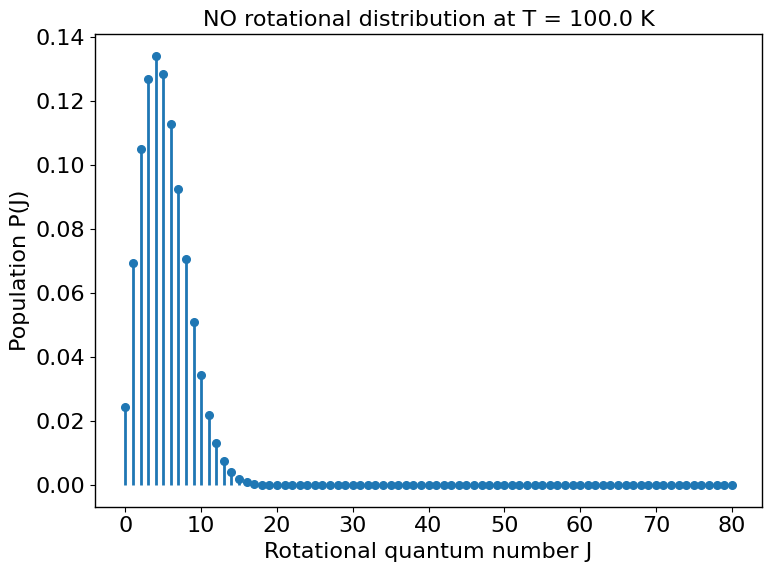

In [12]:
# Rotational distribution for NO at a given temperature (Boltzmann over J)

def rotational_distribution_NO(T, J_max=80):
    """
    Compute the normalized rotational population P(J) for NO at temperature T (K).
    
    Parameters
    ----------
    T : float
        Rotational temperature in Kelvin.
    J_max : int
        Maximum rotational quantum number to include.
        
    Returns
    -------
    J : np.ndarray
        Array of J values (0..J_max).
    P : np.ndarray
        Normalized population P(J) (sum P = 1).
    """
    # Rotational constant of NO in cm^-1 (approx.)
    B = 1.704  # cm^-1
    
    # k_B / (h c) in cm^-1 / K
    kB_over_hc = 0.69503476  # cm^-1/K
    
    J = np.arange(0, J_max + 1)
    
    # E_J / (k_B T) using spectroscopic units
    E_over_kT = B * J * (J + 1) / (kB_over_hc * T)
    
    # Include degeneracy (2J+1)
    weights = (2 * J + 1) * np.exp(-E_over_kT)
    P = weights / weights.sum()
    return J, P

# === Set the temperature you want here (in K) ===
T_rot = 100.0  # replace with the temperature you send, e.g. 150.0, 500.0, etc.

# Compute distribution
J, P = rotational_distribution_NO(T_rot, J_max=80)

# Plot
plt.figure()
plt.stem(J, P, basefmt=" ")
plt.xlabel("Rotational quantum number J")
plt.ylabel("Population P(J)")
plt.title(f"NO rotational distribution at T = {T_rot:.1f} K")
plt.tight_layout()
plt.show()

# Optional: if you want to draw random J samples from this distribution:
# n_samples = 10000
# J_samples = np.random.choice(J, size=n_samples, p=P)

Mixture fit:
  Component 1: T = 629.8 K, weight = 0.790
  Component 2: T = 2900.5 K, weight = 0.210


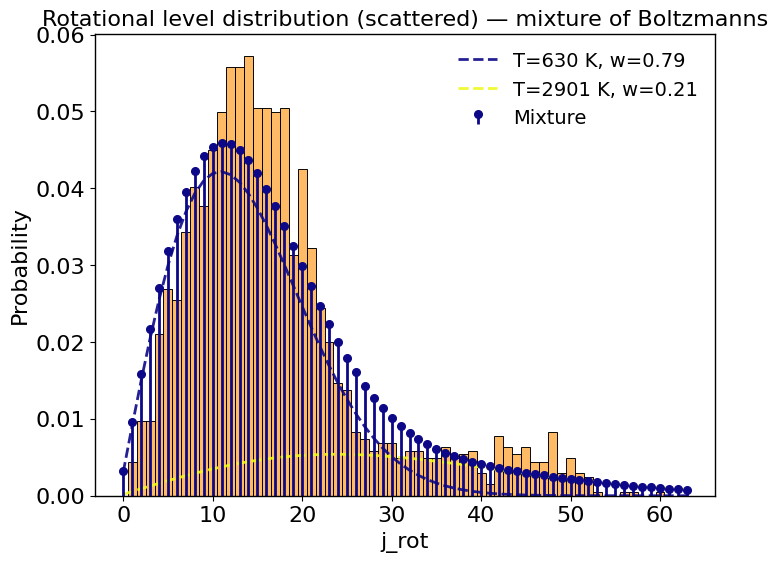

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
from scipy.constants import k as kB

# --- constants for NO (X^2Π) ---
B_cm = 1.696            # rotational constant (cm^-1)
hc   = 1.98630e-23      # J·cm
B_J  = B_cm * hc        # J

def E_J(J):
    # rigid-rotor energy in Joules
    return B_J * J * (J + 1.0)

def g_J(J, extra=1.0):
    # rotational degeneracy; set extra=2.0 if you want to fold in an extra ladder
    return extra * (2.0*J + 1.0)

# ---------- single-temperature negative log-likelihood (your original) ----------
def neg_loglike(T, J_obs, Jgrid, extra_g=1.0):
    E = E_J(Jgrid)
    w = g_J(Jgrid, extra=extra_g) * np.exp(-E / (kB*T))
    Z = w.sum()
    p = w / Z

    Ji = np.rint(J_obs).astype(int)
    idx = Ji - Jgrid[0]
    idx = idx[(idx >= 0) & (idx < len(Jgrid))]

    ll = np.log(p[idx]).sum()
    return -ll

def fit_Trot_MLE(j_samples, g_extra=1.0, Jpad=3, T_bounds=(1.0, 5000.0)):
    j_samples = np.asarray(j_samples, float)
    if j_samples.size == 0:
        raise ValueError("No j_rot samples.")

    jmin = int(np.floor(j_samples.min()))
    jmax = int(np.ceil(j_samples.max()))
    Jgrid = np.arange(max(0, jmin - Jpad), jmax + Jpad + 1, dtype=int)

    obj = lambda T: neg_loglike(T, j_samples, Jgrid, extra_g=g_extra)
    res = minimize_scalar(obj, bounds=T_bounds, method="bounded")
    T_fit = float(res.x)

    eps = 1e-2 * T_fit if T_fit > 0 else 1e-2
    f0  = obj(T_fit)
    fp  = obj(T_fit + eps)
    fm  = obj(T_fit - eps)
    d2  = (fp - 2*f0 + fm) / (eps**2)
    sigma_T = np.sqrt(1.0 / d2) if d2 > 0 else np.nan

    return T_fit, sigma_T, Jgrid

# ---------- NEW: mixture of N temperatures ----------

def neg_loglike_mixture(theta, J_obs, Jgrid, n_comp, extra_g=1.0):
    """
    theta = [logT_1,...,logT_n, a_1,...,a_n]
    T_i = exp(logT_i) > 0
    w_i = softmax(a_i) in (0,1), sum w_i = 1
    """
    theta = np.asarray(theta, float)
    logT = theta[:n_comp]
    a    = theta[n_comp:]

    T = np.exp(logT)
    w_comp = np.exp(a)
    w_comp /= w_comp.sum()

    E = E_J(Jgrid)

    # p_i(J) for each component
    p_components = []
    for Ti in T:
        wi = g_J(Jgrid, extra=extra_g) * np.exp(-E / (kB*Ti))
        p_components.append(wi / wi.sum())
    p_components = np.vstack(p_components)   # shape (n_comp, nJ)

    # mixture probability
    p_mix = w_comp @ p_components           # shape (nJ,)
    eps = 1e-300
    p_mix = np.clip(p_mix, eps, 1.0)

    # log-likelihood on observed Js
    Ji = np.rint(J_obs).astype(int)
    idx = Ji - Jgrid[0]
    idx = idx[(idx >= 0) & (idx < len(Jgrid))]
    ll = np.log(p_mix[idx]).sum()
    return -ll

def fit_Trot_mixture_MLE(j_samples, n_comp=2, g_extra=1.0,
                         Jpad=3, T_bounds=(1.0, 5000.0)):
    """
    Fit a mixture of n_comp rotational temperatures.
    Returns:
        T_fits  : array of fitted temperatures [K]
        w_fits  : array of mixture weights (sum to 1)
        Jgrid   : J grid used
    """
    j_samples = np.asarray(j_samples, float)
    if j_samples.size == 0:
        raise ValueError("No j_rot samples.")

    # grid
    jmin = int(np.floor(j_samples.min()))
    jmax = int(np.ceil(j_samples.max()))
    Jgrid = np.arange(max(0, jmin - Jpad), jmax + Jpad + 1, dtype=int)

    # get a crude single-T estimate as a scale for initial guesses
    T_single, _, _ = fit_Trot_MLE(j_samples, g_extra=g_extra,
                                  Jpad=Jpad, T_bounds=T_bounds)
    # initial Ts around T_single
    T_init = np.linspace(0.5*T_single, 1.5*T_single, n_comp)
    logT0  = np.log(T_init)
    a0     = np.zeros(n_comp)   # equal weights → softmax(a0) = 1/n

    theta0 = np.concatenate([logT0, a0])

    obj = lambda th: neg_loglike_mixture(th, j_samples, Jgrid,
                                         n_comp=n_comp, extra_g=g_extra)

    res = minimize(obj, theta0, method="L-BFGS-B")
    theta_opt = res.x

    logT_opt = theta_opt[:n_comp]
    a_opt    = theta_opt[n_comp:]

    T_fits = np.exp(logT_opt)
    w_fits = np.exp(a_opt)
    w_fits /= w_fits.sum()

    return T_fits, w_fits, Jgrid

# ===== integrate with your existing block =====
if j_scattered:
    j_arr = np.asarray(j_scattered, float)

    # --- choose how many components you want in the mixture ---
    n_comp = 2  # e.g. two-temperature fit

    # Fit mixture T_rot
    T_list, w_list, Jgrid = fit_Trot_mixture_MLE(j_arr, n_comp=n_comp, g_extra=1.0)
    print("Mixture fit:")
    for i, (Ti, wi) in enumerate(zip(T_list, w_list), start=1):
        print(f"  Component {i}: T = {Ti:.1f} K, weight = {wi:.3f}")

    # Histogram of data
    import seaborn as sns
    sns.histplot(
        j_arr,
        bins=np.arange(np.floor(j_arr.min())-0.5, np.ceil(j_arr.max())+1.5, 1),
        kde=False, color="darkorange", stat='probability', alpha=0.6
    )

    # Build mixture PMF and optionally show each component
    E = E_J(Jgrid)
    p_mix = np.zeros_like(Jgrid, dtype=float)

    #plt.rcParams["axes.prop_cycle"] = cycler(
    #color=plt.cm.plasma(np.linspace(0, 1, len(T_list))))
    for Ti, wi in zip(T_list, w_list):
        wJ = g_J(Jgrid, 1.0) * np.exp(-E/(kB*Ti))
        pJ = wJ / wJ.sum()
        p_mix += wi * pJ
        # optional: plot each component as thin lines
        plt.plot(Jgrid, pJ * wi, linestyle='--', alpha=0.9,
                 label=f"T={Ti:.0f} K, w={wi:.2f}")

    # mixture as stems
    plt.stem(Jgrid, p_mix, basefmt=" ", label="Mixture")

    plt.xlabel("j_rot")
    plt.ylabel("Probability")
    ttl = "Rotational level distribution (scattered) — mixture of Boltzmanns"
    plt.title(ttl)
    plt.legend()
    plt.show()

else:
    print("No j_rot samples for scattered molecules.")